# Computer Vision - Face Recognition Project

### Importing necessary libraries

In [ ]:
#to load files
import os
from zipfile import ZipFile

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

# TensorFlow libs
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tqdm.notebook import tqdm

#Libs for image loading and processing
import pathlib
import cv2
import PIL
import glob
import random

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer,
    classification_report
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#for reading h5 files
import h5py

# to suppress, ignore warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")


In [ ]:
tf.__version__

'2.18.0'

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### Background/Context
Company X owns a movie application and repository that caters to movie streaming to millions of users on a subscription basis. The company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on the cast information button, the app will show details of the actor in the scene. The company has in-house computer vision and multimedia experts who need to detect faces from screenshots of the movie scene.

## Part A

### Objective

To build a face detection system.

### Data Dictionary

The data set contains below information:

- **label**: Identifies the object in the image.
- **notes**: Additional comments (currently empty).
- **points**: Co-ordinates of the mask (top-left and bottom-right).
- **imageWidth**: Width of the image in pixels.
- **imageHeight**: Height of the image in pixels.

### Data Preprocessing and Visualization

In [ ]:
#please modify the path accordingly to your setup/files placed before running this code section.
path="/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/Images.npy"
#load the images with np
data = np.load(path,allow_pickle=True)

In [ ]:
#details of the dataset
print('The shape of the dataset:', data.shape)
print('There are',data.shape[0],'images in the dataset')
print('type of image:',type(data[0][0]))
print('type of its labels:',type(data[0][1]))
print('The shape of a sample image:', data[0][0].shape)

The shape of the dataset: (393, 2)
There are 393 images in the dataset
type of image: <class 'numpy.ndarray'>
type of its labels: <class 'list'>
The shape of a sample image: (333, 650, 3)


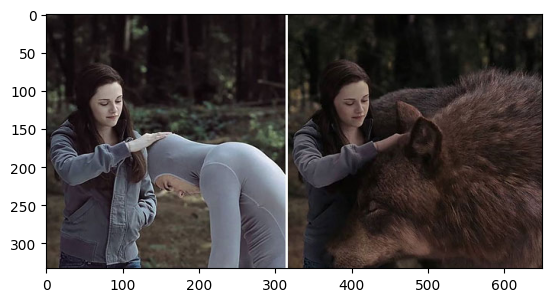

In [ ]:
#sample Image
plt.imshow(data[0][0])

In [ ]:
#sample labels
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

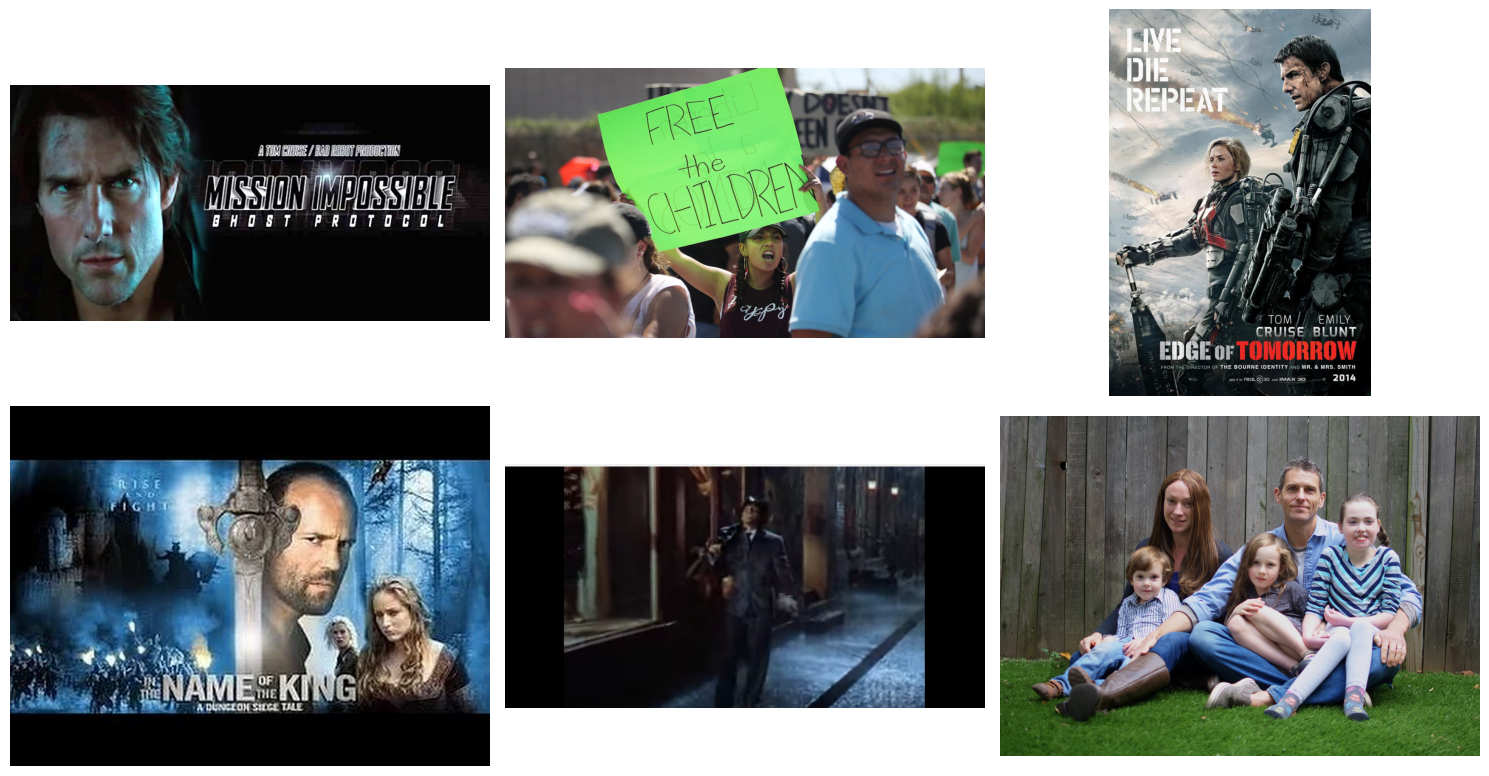

In [ ]:
# Display some images
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

random_indices = np.random.choice(len(data), 6, replace=False)
for i, idx in enumerate(random_indices):
    row = i // 3
    col = i % 3
    axs[row, col].imshow(data[idx][0])
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Collect images and its masks into objects

#set image dimensions
IMG_WIDTH = 224
IMG_HEIGHT = 224

#create objects - Image and Mask
images = np.zeros((int(data.shape[0]), IMG_HEIGHT, IMG_WIDTH, 3))
masks = np.zeros((int(data.shape[0]), IMG_HEIGHT, IMG_WIDTH))

#load images and masks into its objects
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    images[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMG_WIDTH)
        y1 = int(i["points"][0]['y'] * IMG_HEIGHT)
        x2 = int(i["points"][1]['x'] * IMG_WIDTH)
        y2 = int(i["points"][1]['y'] * IMG_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print('Shape of Images:',images.shape)
print('Shape of Masks:',masks.shape)

Shape of Images: (393, 224, 224, 3)
Shape of Masks: (393, 224, 224)


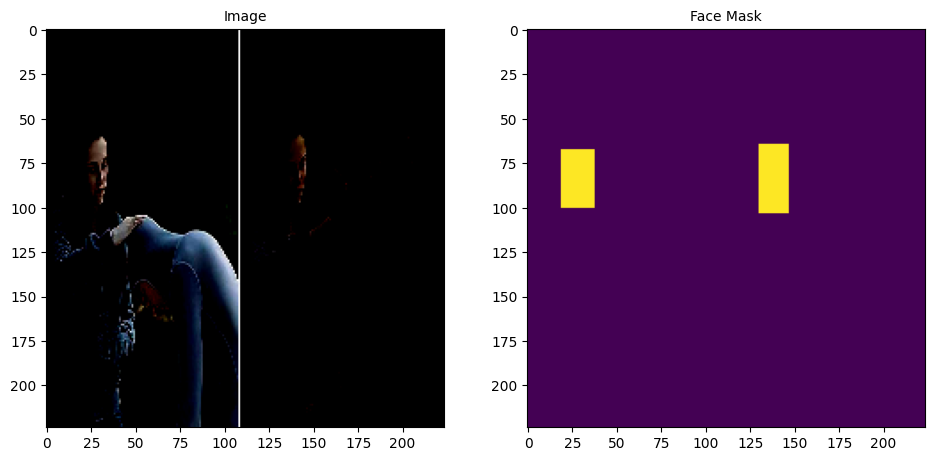

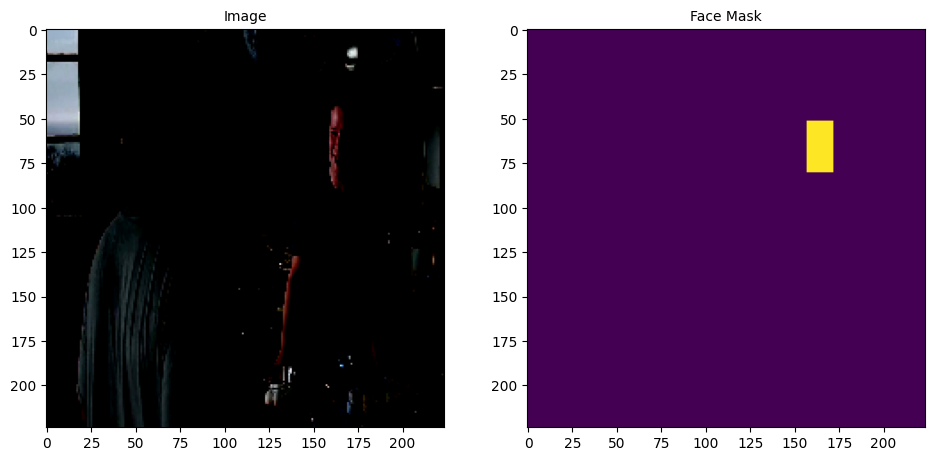

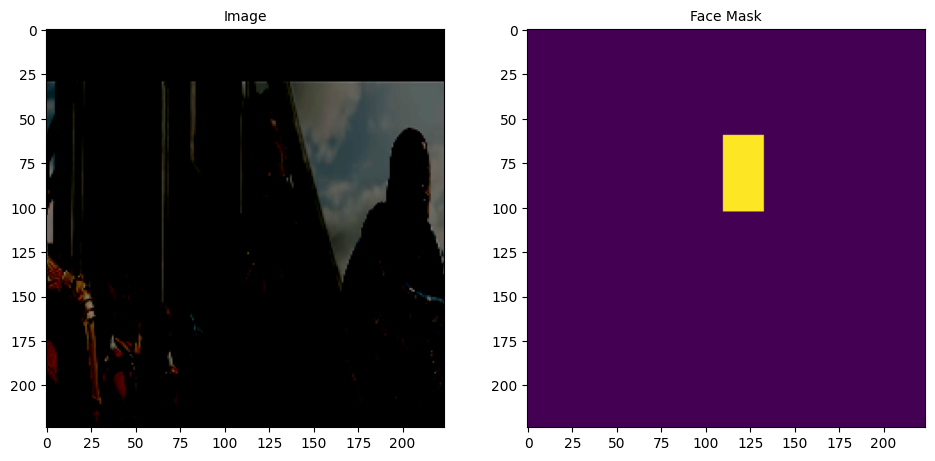

In [ ]:
#Lets vizualize some images and its mask
for i in range (3):
  plt.figure(figsize=(30,30))
  plt.subplot(5,5,1)
  plt.title("Image",fontsize=10)
  plt.imshow(images[i])
  plt.subplot(5,5,2)
  plt.title("Face Mask",fontsize=10)
  plt.imshow(masks[i])

In [ ]:
# Split data into train and test sets in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)
print('Shape of X_Train(images):',X_train.shape)
print('Shape of y_train(masks):',y_train.shape)
print('Shape of X_test(images):',X_test.shape)
print('Shape of y_test(masks):',y_test.shape)

Shape of X_Train(images): (275, 224, 224, 3)
Shape of y_train(masks): (275, 224, 224)
Shape of X_test(images): (118, 224, 224, 3)
Shape of y_test(masks): (118, 224, 224)


### Model Building and Evaluation

In [ ]:
from keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#function to create unet model using MobileNet
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMG_HEIGHT, IMG_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [ ]:
fd_model= create_model()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [ ]:
fd_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,230,849 (12.32 MB)

 Trainable params: 3,208,961 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

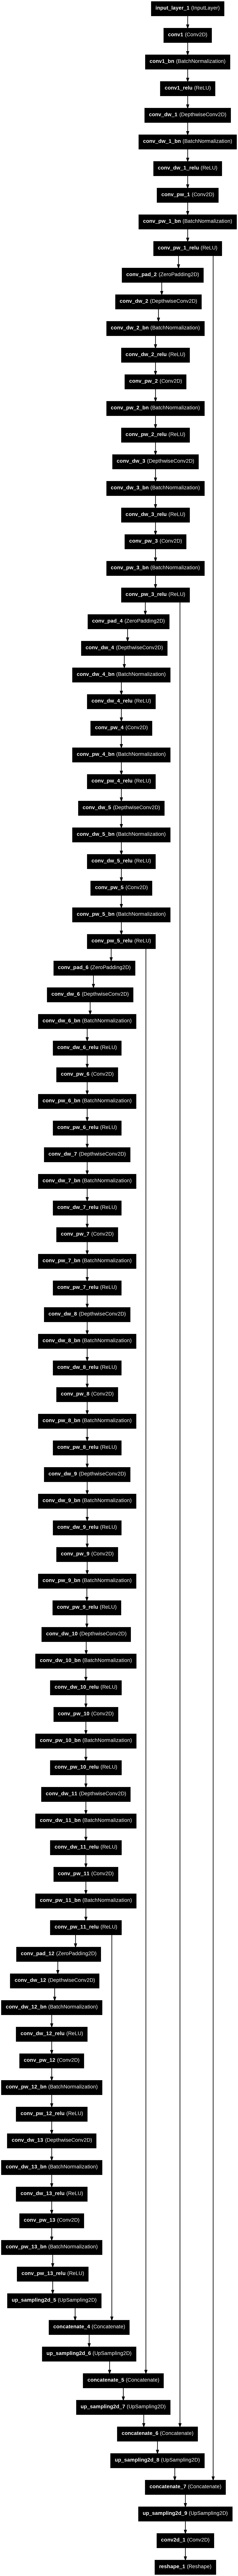

In [ ]:
# Checking the model network
tf.keras.utils.plot_model(fd_model,to_file='fd_model.png',show_layer_names=True)

In [ ]:
# function to calculate Dice Coefficient
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [ ]:
# function to calculate Loss function
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
fd_model.compile(optimizer=Adam(),loss= dice_loss,metrics=[dice_coeff])

In [ ]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.weights.h5", monitor="loss", verbose=1, save_best_only=True,save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
history = fd_model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coeff: 0.4306 - loss: 0.5694
Epoch 1: loss improved from inf to 0.52151, saving model to model-0.52.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - dice_coeff: 0.4312 - loss: 0.5688 - learning_rate: 0.0010
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coeff: 0.5591 - loss: 0.4409
Epoch 2: loss improved from 0.52151 to 0.43187, saving model to model-0.43.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - dice_coeff: 0.5592 - loss: 0.4408 - learning_rate: 0.0010
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - dice_coeff: 0.5981 - loss: 0.4019
Epoch 3: loss improved from 0.43187 to 0.39937, saving model to model-0.40.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - dice_coeff: 0.5981 - loss: 0.4019 - learning_rate: 0.0010
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coeff: 0.6215 - loss: 0.3785
Epoch 4: loss improved from 0.39937 to 0.38045, saving model to model-0.38.weights

In [ ]:
score = fd_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - dice_coeff: 0.5959 - loss: 0.4036
Test loss: 0.4119998514652252
Test accuracy: 0.5866068005561829


In [ ]:
#function to predict the mask for given image and display against original image, mask
def predict(image_index):
  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
  ax1.imshow(X_test[image_index])
  ax1.set_title("Original Image")
  ax2.imshow(y_test[image_index])
  ax2.set_title("Original Mask")
  ax3.imshow(fd_model.predict(X_test[image_index].reshape(1,224,224,3))[0])
  ax3.set_title("Predicted Mask")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


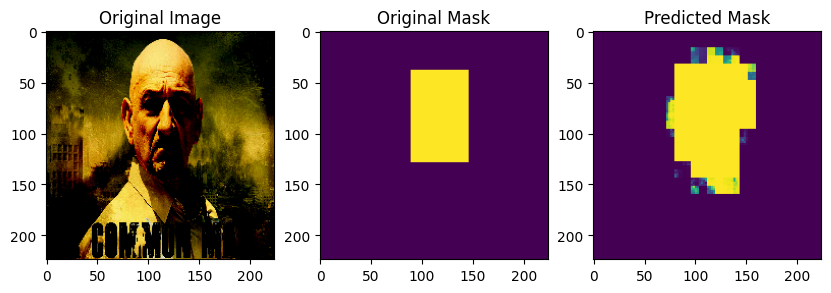

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


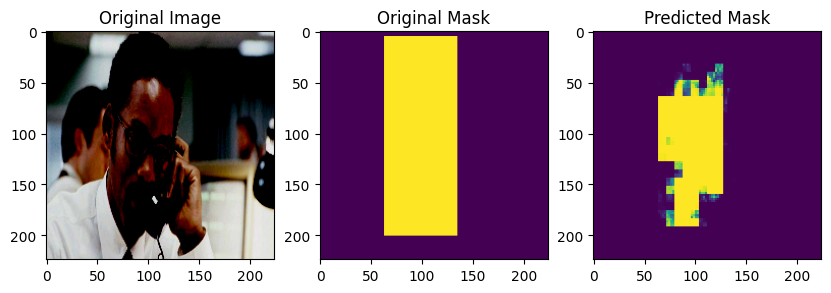

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


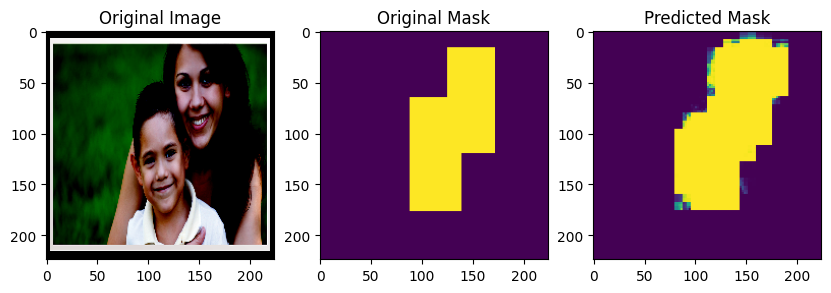

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


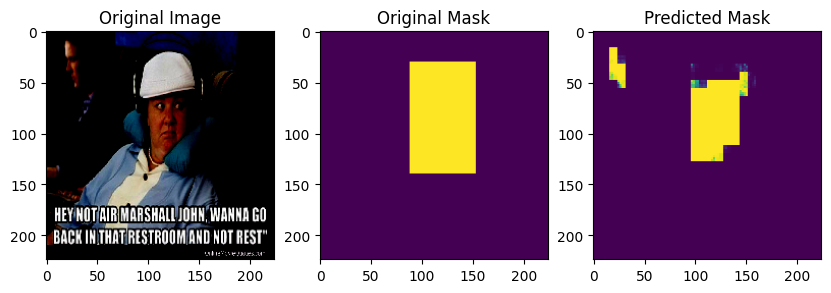

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


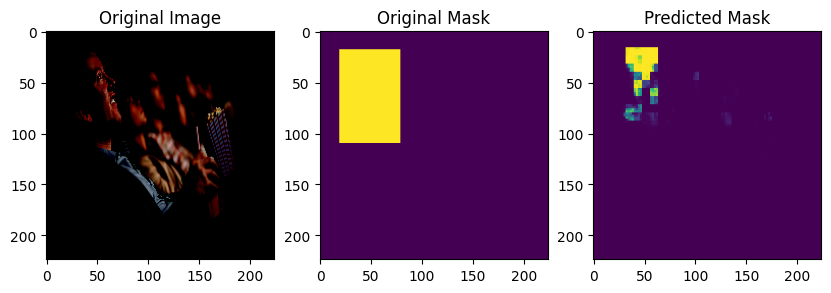

In [ ]:
random_indices2 = random.choices(range(0,117), k=5)

for i in random_indices2:
  predict(i)

### Predicting Face Masks from Images

In [ ]:
import os
os.chdir('/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/')

import cv2
import os
import pandas as pd
from zipfile import ZipFile

#Unzip the ZIP file
zip_file_path = 'training_images-20211126T092819Z-001.zip'
unzip_folder = 'unzipped_training_images'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder)

# Path to the training images folder
training_images_path = unzip_folder+"/training_images"

# Create a cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Get a list of all training images
files = os.listdir(training_images_path)

# Create an empty DataFrame to store the face metadata
face_data = pd.DataFrame()

# Create an empty DataFrame with a default value for the "total_faces" column
face_data = pd.DataFrame({"total_faces": 0}, index=[0])

#loop through images
for file_name in files:
     # Read image
    image_path = os.path.join(training_images_path, file_name)
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Unable to read image '{file_name}'.So Skipping it.")
        continue

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Step 3: Extract metadata of faces
    for (x,y,w,h) in faces:
       # Create a dictionary to store the metadata for each face
        face_metadata = {
            "x": x,
            "y": y,
            "w": w,
            "h": h,
            "total_faces": len(faces),
            "filename": file_name
        }

    # Add the face metadata to the DataFrame
    face_data = pd.concat([face_data, pd.DataFrame(face_metadata, index=[0])], ignore_index=True)

# Print the face data DataFrame (has face metadata details as well)
print(face_data)

      total_faces     x      y      w      h        filename
0               0   NaN    NaN    NaN    NaN             NaN
1               1  87.0  131.0  430.0  430.0  real_00448.jpg
2               1  88.0  169.0  380.0  380.0  real_00415.jpg
3               1  41.0  125.0  413.0  413.0  real_00405.jpg
4               1  41.0  125.0  413.0  413.0  real_00405.jpg
...           ...   ...    ...    ...    ...             ...
1087            1  77.0  143.0  430.0  430.0  real_00449.jpg
1088            1  63.0  147.0  430.0  430.0  real_00378.jpg
1089            1  63.0  147.0  430.0  430.0  real_00378.jpg
1090            1  52.0   68.0  470.0  470.0  real_00330.jpg
1091            1  60.0   78.0  437.0  437.0  real_00399.jpg

[1092 rows x 6 columns]


In [ ]:
face_data.head(15)

total_faces      x      y      w      h        filename
0             0    NaN    NaN    NaN    NaN             NaN
1             1   87.0  131.0  430.0  430.0  real_00448.jpg
2             1   88.0  169.0  380.0  380.0  real_00415.jpg
3             1   41.0  125.0  413.0  413.0  real_00405.jpg
4             1   41.0  125.0  413.0  413.0  real_00405.jpg
5             1   41.0  125.0  413.0  413.0  real_00405.jpg
6             1   41.0  125.0  413.0  413.0  real_00405.jpg
7             1  224.0  204.0  303.0  303.0  real_00362.jpg
8             1   79.0  344.0   53.0   53.0  real_00354.jpg
9             1   58.0  117.0  453.0  453.0  real_00432.jpg
10            1   33.0  156.0  430.0  430.0  real_00343.jpg
11            1   33.0  156.0  430.0  430.0  real_00343.jpg
12            1   33.0  156.0  430.0  430.0  real_00343.jpg
13            1   33.0  156.0  430.0  430.0  real_00343.jpg
14            1  108.0  157.0  379.0  379.0  real_00467.jpg

In [ ]:
#save the face data as csv file
face_data.to_csv("/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/face_data.csv", index=False)

## Part B

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Objective

 To create an image dataset to be used by the AI team to build image classifier data.

### Data Dictionary

The dataset comprises facial images (PINS.zip) that may contain either multiple individuals or a single individual per image.

### Data Preprocessing

In [ ]:
# Defines the zip file path, imports the library and extracts all the files
images_file_zip = '/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/PINS.zip'   # Defines the path to the zip file
from zipfile import ZipFile                                                           # Imports the ZipFile library
with ZipFile(images_file_zip, 'r') as zip:                                            # Extracts the files from the Zip file to the current working directory
  zip.extractall()

In [ ]:
#Defines a Python class called IdentityMetadata
class IdentityMetadata():
    def __init__(self, base, name, file):                                        #constructor method for the IdentityMetadata class
        # print(base, name, file)
        # dataset base directory
        self.base = base                                                         #base URL of the identity provider
        # identity name
        self.name = name                                                         #name of the  identity provider
        # image file name
        self.file = file                                                         #path to the file containing the identity provider's metadata

    def __repr__(self):                                                          #special method - return a string representation of an object
        return self.image_path()                                                 #string - represents the path to the image being classified

    def image_path(self):                                                        #property that returns the value of the self.image_path attribute
        return os.path.join(self.base, self.name, self.file)                     #constructs path to the image file

In [ ]:
def load_metadata(path):                                      #loads the metadata of an image from a given path
    metadata = []                                             #list to store the metadata for an image
    for i in os.listdir(path):                                #Iterates through subdirectories in the given directory.
        for f in os.listdir(os.path.join(path, i)):           #Iterates through files in each subdirectory.
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':               #If the file has a .jpg or .jpeg extension,
                metadata.append(IdentityMetadata(path, i, f)) #an IdentityMetadata object is created and appended to the metadata list.
    return np.array(metadata)                                 #converts the list to a numpy array

In [ ]:
#Extract Metadata and Labels of images
metadata = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [ ]:
print('Total Images:',metadata.size)
print ('Total Labels:',labels.size )

Total Images: 10770
Total Labels: 10770


In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels in BGR order. So reversing them
    return img[...,::-1]

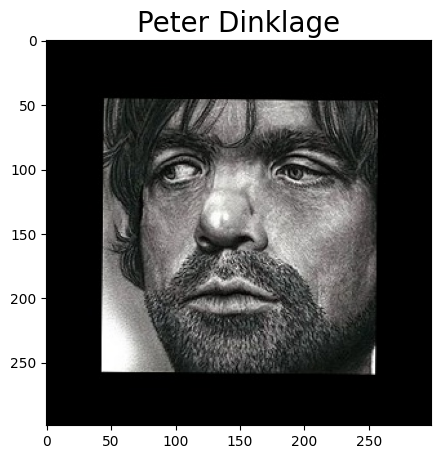

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

# View sample image
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
plt.imshow(img);

### Visualizing Similar Images

In [ ]:
#function to build vgg model
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
vgg_model = vgg_face() #calls the vgg_face function to load the VGGFace model with the top layer included.
vgg_model.load_weights('/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/vgg_face_weights.h5')   #loads the weights for the model from the specificed path.
vgg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d_13               │ (None, 226, 226, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_14               │ (None, 226, 226, 64)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_15               │ (None, 114, 114, 64)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_16               │ (None, 114, 114, 128)  │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_17               │ (None, 58, 58, 128)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_18               │ (None, 58, 58, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_19               │ (None, 58, 58, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_20               │ (None, 30, 30, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_21               │ (None, 30, 30, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#vgg_model.layers[0] = input layer = first layer in the model.
#vgg_model.layers[-2] =output layer = second-to-last layer in the model.
vgg_face_descriptor = Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-2].output) # the new model takes same input as the original model and produce the same output as the second-to-last layer of the original model.

In [ ]:
#Embedding vectors of images, also known as image embeddings, are numerical representations of images that capture their visual content and semantic meaning.
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalizing pixel values from [0-255] to [0-1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print("The shape of the image is {}".format(img.shape))

# Obtain and get the embedding vector for the above image using vgg_face_descriptor model
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print("The shape of the Embedded vector is {}".format(embedding_vector.shape))

The shape of the image is (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
The shape of the Embedded vector is (2622,)


- The image has a height of 224 pixels, a width of 224 pixels, and 3 channels (RGB).
- The embedding vector for the image is a NumPy array with 2622 elements.(This means that the vgg_face_descriptor model has extracted 2622 features from the image.)
- These features can be used for a variety of tasks, such as: Face recognition, Gender classification etc.

In [ ]:
# Generate embeddings
embdngs = []
embdngs = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embdngs[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embdngs[i] = np.zeros(2622)

np.save('/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/embdngs.npy', np.array(embdngs))

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━

In [ ]:
embdngs.shape

(10770, 2622)

In [ ]:
embdngs2 = np.load('/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/embdngs.npy')
embdngs2.shape

(10770, 2622)

In [ ]:
# Consider distance metric as "Squared L2 distance (Euclidean distance)"
# Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2
# This function calculates the distance between the embedding vectors for two images.
# If the distance is small, then the two images are likely to be of the same person.
# Otherwise, the two images are likely to be of different people.

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
# Function to pair plotting the images with its distances
# Threshold set = 0.5

def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    dist= distance(embdngs[idx1], embdngs[idx2])
    threshold = 0.5

    if dist < threshold:
        title = ' < threshold, => SIMILAR'
    else:
        title = ' > threshold, => DISSIMILAR'

    plt.title('Distance ='+str(dist.round(2))+title)
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

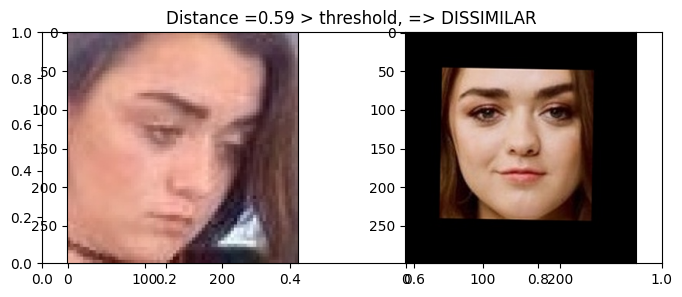

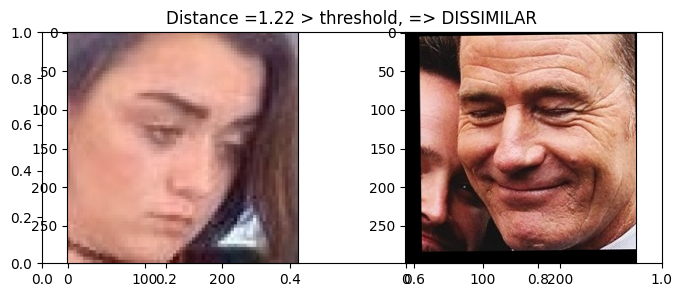

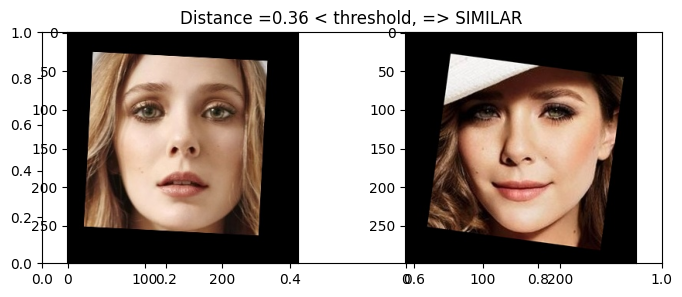

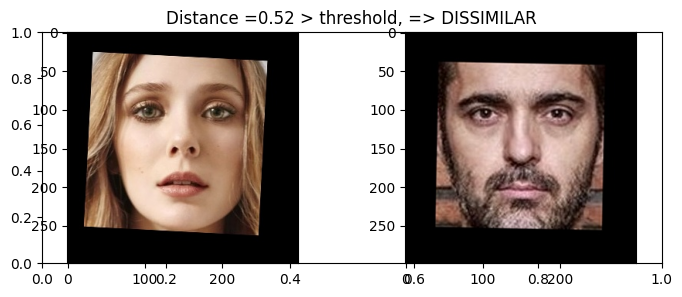

In [ ]:
# Display images and distance between them
show_pair(10, 11)
show_pair(10, 1000)
show_pair(800, 801)
show_pair(800, 1200)

## Part C

In [ ]:
#Split X_train, X_test and y_train, y_test
#Use train_idx to seperate out training features and labels
#Use test_idx to seperate out testing features and labels

train_idx = np.arange(metadata.shape[0]) % 9 != 0     # This array contains the indices of all the elements in the metadata array that are not multiples of 9
test_idx = np.arange(metadata.shape[0]) % 9 == 0      # This array contains the indices of all the elements in the metadata array that are multiples of 9.

# Features
# one half as train examples of 10 identities
X_train = embdngs[train_idx]                # X_train array will contain the embedding vectors for all of the elements in the metadata array that are not multiples of 9.
# another half as test examples of 10 identities
X_test = embdngs[test_idx]                  # X_test array will contain the embedding vectors for all of the elements in the metadata array that are multiples of 9.

#Labels as targets
targets = np.array([m.name for m in metadata]) # uses a list comprehension to extract the names of all of the people in the metadata array and store them in the targets array.
#train labels
y_train = targets[train_idx]                   # y_train array will contain the names of all of the people in the metadata array that are not multiples of 9.
#test labels
y_test = targets[test_idx]                     # y_test array will contain the names of all of the people in the metadata array that are multiples of 9.

print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [ ]:
# Encode the targets
# Use LabelEncoder
encoder = LabelEncoder()

# Numerical encoding of identities/Labels
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Standarizing features - PCA requires standardized data, lets standardize the data to ensure that all variables have a mean of 0 and a standard deviation of 1.
sc = StandardScaler()
X_train_stdrd = sc.fit_transform(X_train)
X_test_stdrd = sc.transform(X_test)

print('X_train_stdrd shape : ({0},{1})'.format(X_train_stdrd.shape[0], X_train_stdrd.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_stdrd shape : ({0},{1})'.format(X_test_stdrd.shape[0], X_test_stdrd.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_stdrd shape : (9573,2622)
y_train_encoded shape : (9573,)
X_test_stdrd shape : (1197,2622)
y_test_encoded shape : (1197,)


In [ ]:
# Reduce feature dimensions using Principal Component Analysis
# Setting the parameter n_components=128
from sklearn.decomposition import PCA

pri_comp_ana = PCA(n_components=128)                     #keep the top 128 principal components
X_train_pca = pri_comp_ana.fit_transform(X_train_stdrd)  #first fits the PCA object to the data
X_test_pca = pri_comp_ana.transform(X_test_stdrd)        #uses the PCA object to transform the X_test_std array

print("Shape of dimensionally reduced data {}, {}".format(X_train_pca.shape, X_test_pca.shape))

Shape of dimensionally reduced data (9573, 128), (1197, 128)


In [ ]:
from sklearn.svm import SVC

svc = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 7)
svc.fit(X_train_pca, y_train_encoded)
print('SVC Accuracy on Train data is: {0:.2f}'.format(svc.score(X_train_pca, y_train_encoded)))

SVC Accuracy on Train data is: 1.00


In [ ]:
# Predict
y_pred = svc.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {0:.2f}'.format(accuracy_score(y_test_encoded, y_pred)))

Accuracy Score: 0.95


In [ ]:
# Classification Report for each person
names = [name.split('_')[1].title().strip() for name in labels]
print('Classification Report: \n{}'.format(classification_report(y_test_encoded, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      0.92      0.96        13
Alycia Debnam Carey Face       1.00      0.92      0.96        13
             Amanda Crew       1.00      0.88      0.93         8
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      0.88      0.93         8
               Anna Gunn       0.94      1.00      0.97        15
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       0.90      1.00      0.95         9
      Bellamy Blake Face       0.50      0.92      0.65        13
    Benedict Cumberbatch       1.00      0.92      0.96        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.78      0.78      

In [ ]:
#Defines a Python class called IdentityMetadata2 for test images data
class IdentityMetadata2():
    def __init__(self, base, name):                                              #constructor method for the IdentityMetadata class
        # print(base, name, file)
        # dataset base directory
        self.base = base                                                         #base URL of the identity provider
        # identity name
        self.name = name                                                         #name of the  identity provider
        # image file name
        #self.file = file                                                        #path to the file containing the identity provider's metadata

    def __repr__(self):                                                          #special method - return a string representation of an object
        return self.image_path()                                                 #string - represents the path to the image being classified

    def t_image_path(self):                                                      #property that returns the value of the self.image_path attribute
        return os.path.join(self.base, self.name)

In [ ]:
def load_metadata2(path):                                     #loads the metadata of test images from a given path
    metadata_test = []                                        #list to store the metadata for an image
    for i in os.listdir(path):
      ext = os.path.splitext(i)[1]
      if ext == '.jpg' or ext == '.jpeg':                     #If the file has a .jpg or .jpeg extension,
        metadata_test.append(IdentityMetadata2(path, i))      #an IdentityMetadata object is created and appended to the metadata list.
    return np.array(metadata_test)                            #converts the list to a numpy array

In [ ]:
#Extract Metadata and Labels of test images
metadata_t = load_metadata2('/content/drive/MyDrive/PGP-AIML/ComputerVision/Project/')
labels_t = np.array([meta.name for meta in metadata_t])

In [ ]:
print('Total Images:',metadata_t.size)
print ('Total Labels:',labels_t )

Total Images: 2
Total Labels: ['Benedict+Cumberbatch9.jpg' 'Dwayne+Johnson4.jpg']


In [ ]:
def t_load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels in BGR order. So reversing them
    return img[...,::-1]

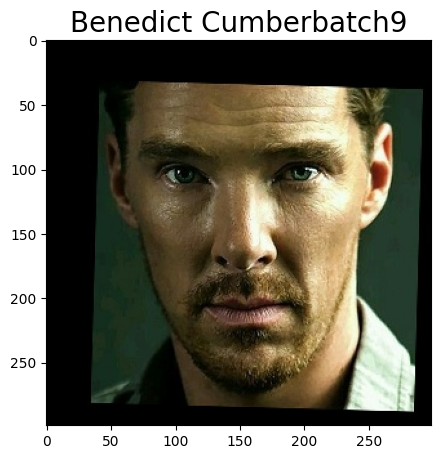

In [ ]:
#n = np.random.randint(1, len(metadata_t))
n =0
t_img_path = metadata_t[n].t_image_path()
t_img = t_load_image(t_img_path)

# View sample image
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
label2=labels_t[n].split('.')[0]
title = label2.split('+')[0] +' '+label2.split('+')[1]
ax.set_title(title, fontsize = 20)
plt.imshow(t_img);

In [ ]:
t1_idx = np.arange(metadata_t.shape[0]) % 9 == 0
t2_idx = np.arange(metadata_t.shape[0]) % 9 == 1

In [ ]:
print(metadata_t[t1_idx][0].name)
print(metadata_t[t2_idx][0].name)

Benedict+Cumberbatch9.jpg
Dwayne+Johnson4.jpg


In [ ]:
#Function to predict label of given test image and  return the actual , predicted label and the test image
def predict_label(sample_idx, test_who):
  if test_who == 'Benedict':
    t_idx = t1_idx
  elif test_who == 'Dwayne':
    t_idx = t2_idx

  # Load image for sample_idx from test data
  sample_img = t_load_image(metadata_t[t_idx][sample_idx].t_image_path())
  # Get actual name
  actual_name = metadata_t[t_idx][sample_idx].name.split('.')[0].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding_t = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_t_scaled = sc.transform(embedding_t.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pri_comp_ana.transform(embedding_t_scaled)) #using the trained SVM Model to predict labels of test images
  # Transform back
  print(encoder.inverse_transform(sample_pred)[0])
  pred_name = encoder.inverse_transform(sample_pred)[0].split('_')[1].title().strip()
  return sample_img, actual_name, pred_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
pins_Benedict Cumberbatch


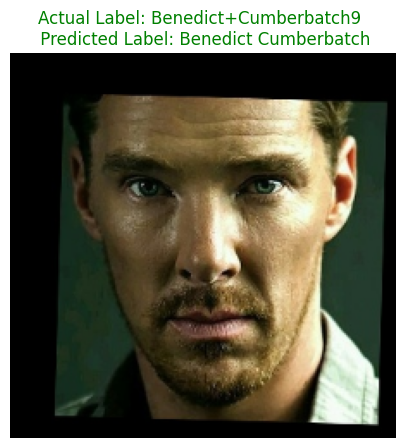

In [ ]:
# Predict and validate for image 1
sample_img1, actual_name1, pred_name1 = predict_label(0,'Benedict')
fig = plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(sample_img1)
plt.title(f"Actual Label: {actual_name1} \n Predicted Label: {pred_name1}", color = 'green')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
pins_Dwayne Johnson


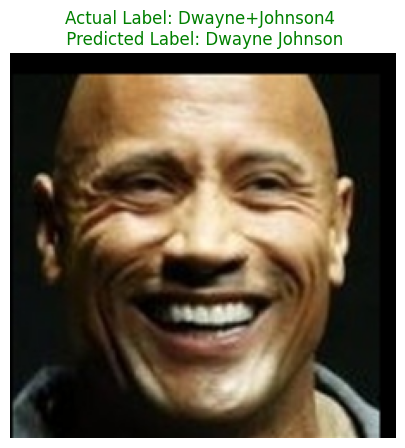

In [ ]:
# Predict and validate for image 2
sample_img2, actual_name2, pred_name2 = predict_label(0,'Dwayne')
fig = plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(sample_img2)
plt.title(f"Actual Label: {actual_name2} \n Predicted Label: {pred_name2}", color = 'green')
plt.show()

## Insights & Recommendations:

**PART A**:
- The Face Detection model built achieved a test loss of 0.41 and a test accuracy of 0.58.
- Test Loss: The test loss value indicates how well the model performs on unseen data (the test set). A lower test loss value generally means the model is making more accurate predictions.
- Test Accuracy: The test accuracy value indicates the percentage of correctly classified examples in the test set. In this case, the model correctly classifies approximately 58.5% of the examples in the test set.
- Dice co-efficient measures the similarity between two sets of data. Dice co-efffient value should be closer to 1 to achieve better predictions. We were able to achieve 0.69 dice co-efficient with loss of 0.31 in 10 epochs on train data which is pretty good.
-  **Model improvement options**:
  - Analyze the model's predictions on the test set to identify misclassified examples and understand why the model made mistakes. This can be done by visualizing the misclassified examples and examining the model's output probabilities.
  - Experiment with different model architectures, hyperparameters, or training strategies to improve the model's performance. For example, increasing the number of training epochs, using a different optimizer, or adding regularization techniques may help to reduce the test loss and improve accuracy.
  - Consider collecting more training data or using data augmentation techniques to improve the model's generalization ability. This can help the model learn more effectively and reduce overfitting.
- The model's performance is moderate, as evidenced by the test accuracy and loss values. There is some room for improvement, as the model is misclassifying nearly half of the examples in the test set. Further analysis is needed to understand the specific types of errors the model is making and identify potential areas for improvement.

**PART B**:
- We could detect only 1 face in some images with multiple faces, there are a few possible reasons why only some faces have been detected:
 - **Insufficient lighting**: The faces that were not detected may be in areas of the image with poor lighting. This can make it difficult for the face detector to recognize them.
 - **Occlusion**: The faces that were not detected may be partially or fully occluded by other objects, such as hands, hair, or sunglasses. This can also make it difficult for the face detector to recognize them.
  - **Angle of the face**: The faces that were not detected may be at an angle that is not ideal for the face detector. For example, if the face is turned sideways or upside down, the face detector may not be able to recognize it.
 - **Size of the face**: The faces that were not detected may be too small or too large for the face detector to recognize.
  - **Quality of the image**: The faces that were not detected may be in images that are blurry, noisy, or have low resolution. This can make it difficult for the face detector to recognize them.

-  **Model improvement options**:
  - Ensure that the images are well-lit and that the faces are not occluded by other objects.
  - Try using a different face detector. There are many different face detectors available, and some may be more accurate than others for your particular application.
  - Experiment with the parameters of the face detector. For example, we can adjust the minimum face size or the scale factor.
  - Try training your own classifier with a larger and more diverse dataset of images.

It is also important to keep in mind that no face detector is perfect. There will always be some faces that are not detected, even with the best face detector.

**PART C**:
 - The SVM classifier has the highest accuracy in training data and higher accuracy on the test data as well so whether it is overfitting or not can be analysed further.
 - The Generation of embeddings vectors of images is time consuming so faster way to extract can be explored further.
 - The label of actual image and test image vary slightly and can be also be matched with string operations on it.